In [3]:
import tensorflow as tf
import src
import src.utils
from keras import layers, models
from keras.layers import (
    Conv2D,
    GlobalAveragePooling2D,
    Dense,
    MaxPooling2D,
    Dropout,
    Input,
    BatchNormalization,
    RandomFlip,
    RandomRotation,
    RandomZoom,
)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from src.labels_maps import fine_id_coarse_id, fine_int2str, coarse_int2str
from livelossplot import PlotLossesKeras

In [ ]:
['train[:80]','train[80:90]', 'test[90:]']

In [ ]:
["train[0%:80%]", "train[80%:]", "test"]

In [4]:
from pathlib import Path
from src.data.preprocess_datasets import LOAD_DIR, SAVE_DIR


def preprocess_datasets(
    batch_size: int = 64,
    *,
    load_dir,
    save_dir
):
    (train_ds, val_ds, test_ds), _ = src.load_dataset(split=["train", "test[:50%]", "test[50%:]"], data_dir=load_dir)

    train_ds = src.dataset_preprocessing(train_ds, batch_size)
    train_ds.save(str(Path(save_dir).joinpath("./train")))

    val_ds = src.dataset_preprocessing(val_ds, batch_size)
    val_ds.save(str(Path(save_dir).joinpath("./validation")))

    test_ds = src.dataset_preprocessing(test_ds, batch_size)
    test_ds.save(str(Path(save_dir).joinpath("./test")))


In [5]:
preprocess_datasets(load_dir=LOAD_DIR, save_dir=SAVE_DIR)

In [6]:
fine_train, fine_val, fine_test = src.load_preprocessed_datasets(label_mode="fine")
coarse_train, coarse_val, coarse_test = src.load_preprocessed_datasets(
    label_mode="coarse"
)

augment_layer = models.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(factor=0.05),
        RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)


@tf.function
def augment_images(image, label):
    return (augment_layer(image), label)


fine_train: tf.data.Dataset = (
    fine_train.unbatch()
    .cache()
    .shuffle(fine_train.cardinality())
    .batch(64, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_images)
    .prefetch(tf.data.AUTOTUNE)
)
coarse_train: tf.data.Dataset = (
    coarse_train.unbatch()
    .cache()
    .shuffle(fine_train.cardinality())
    .batch(64, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_images)
    .prefetch(tf.data.AUTOTUNE)
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12507899943548441171
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 140426784454305894
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

In [19]:
import tensorflow_datasets as tfds

df = list(tfds.as_numpy(fine_train.unbatch()))

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12507899943548441171


In [21]:
fine_val_df = list(tfds.as_numpy(fine_val.unbatch()))

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 140426784454305894


In [20]:
len(df)

50000

In [23]:
def build_model(num_classes: int):
    model = models.Sequential()

    model.add(Input(shape=(32, 32, 3)))
    model.add(layers.Rescaling(scale=1.0 / 255))

    model.add(Conv2D(128, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(Conv2D(256, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(Conv2D(384, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(1024, activation="elu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.0005, decay_steps=5000, decay_rate=0.8, staircase=False
    )

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=["accuracy"],
    )

    return model

## Объяснение модели

### Цвета и кол-во классов

От количества цветов зависит входной слой, где 3 - обозначает кол-во каналов.
```
layers.Input(shape=(32, 32, 3))
```

От количества классов зависит выходной слой, где `num_classes` - количество предсказываемых классов.
```
model.add(Dense(num_classes, activation="softmax"))
```

### Слои и гиперпараметры

#### Слои

Общая схема модели:
```
Сверточный блок
Сверточный блок
Сверточный блок
GlobalAveragePooling2D
Полносвязный слой
```

Сделано 3 блока для извлечения более абстрактных признаков.

Сверточный блок представляет из себя:
1. Conv2D - сверточный слой для извлечения признаков из изображения. `padding="same"` сохраняет размеры признакового слоя после свертки. В качестве функции активации взял ELU, так как он себя лучше показал, чем ReLU.
2. BatchNormalization - батч-нормализация применяется для ускорения обучения и стабилизации обучения модели
3. Conv2D - аналогично первому сверточному слою, но без padding="same" для уменьшения размера признаков
4. BatchNormalization - аналогично п.2.
5. MaxPooling2D - пулинг слой для уменьшения размерности признаков, усредняя значения в квадратных окнах размером 2x2

`GlobalAveragePooling2D` - выбран вместо Flatten. Производит глобальное усреднение признаков. Использует меньшее количество параметров, чем Flatten, что улучшает обобщающую способность модели.

Полносвязный слой состоит из:
1. Dense(1024, activation = "elu") - полносвязный слой с 1024 нейронами для объединения извлеченных признаков
2. BatchNormalization
3. Dropout - для уменьшения переобучения
4. Dense(activation = "softmax")  - выходной слой с количеством нейронов, равным количеству классов, и функцией активации softmax для многоклассовой классификации.

#### Гиперпараметры

ExponentialDecay был выбран для ускорения обучения. Позволяет начать с высокой скорости обучения и постепенно её снижать.

Гиперпараметры подбирались экспериментально.

Слишком большое кол-во фильтров в сверточных слоях приводило к переобучению сети, а недостаточное количество не позволяло модели понять признаки изображений.

## Обучение моделей

In [24]:
TRAIN = True

In [25]:
early_stop_loss = EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.001,
    verbose=1,
    patience=10,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=4, min_lr=0.00001, min_delta=0.001
)


def get_callbacks():
    return [
        early_stop_loss,
        reduce_lr,
        PlotLossesKeras(),
    ]

#### Обучение по широким меткам

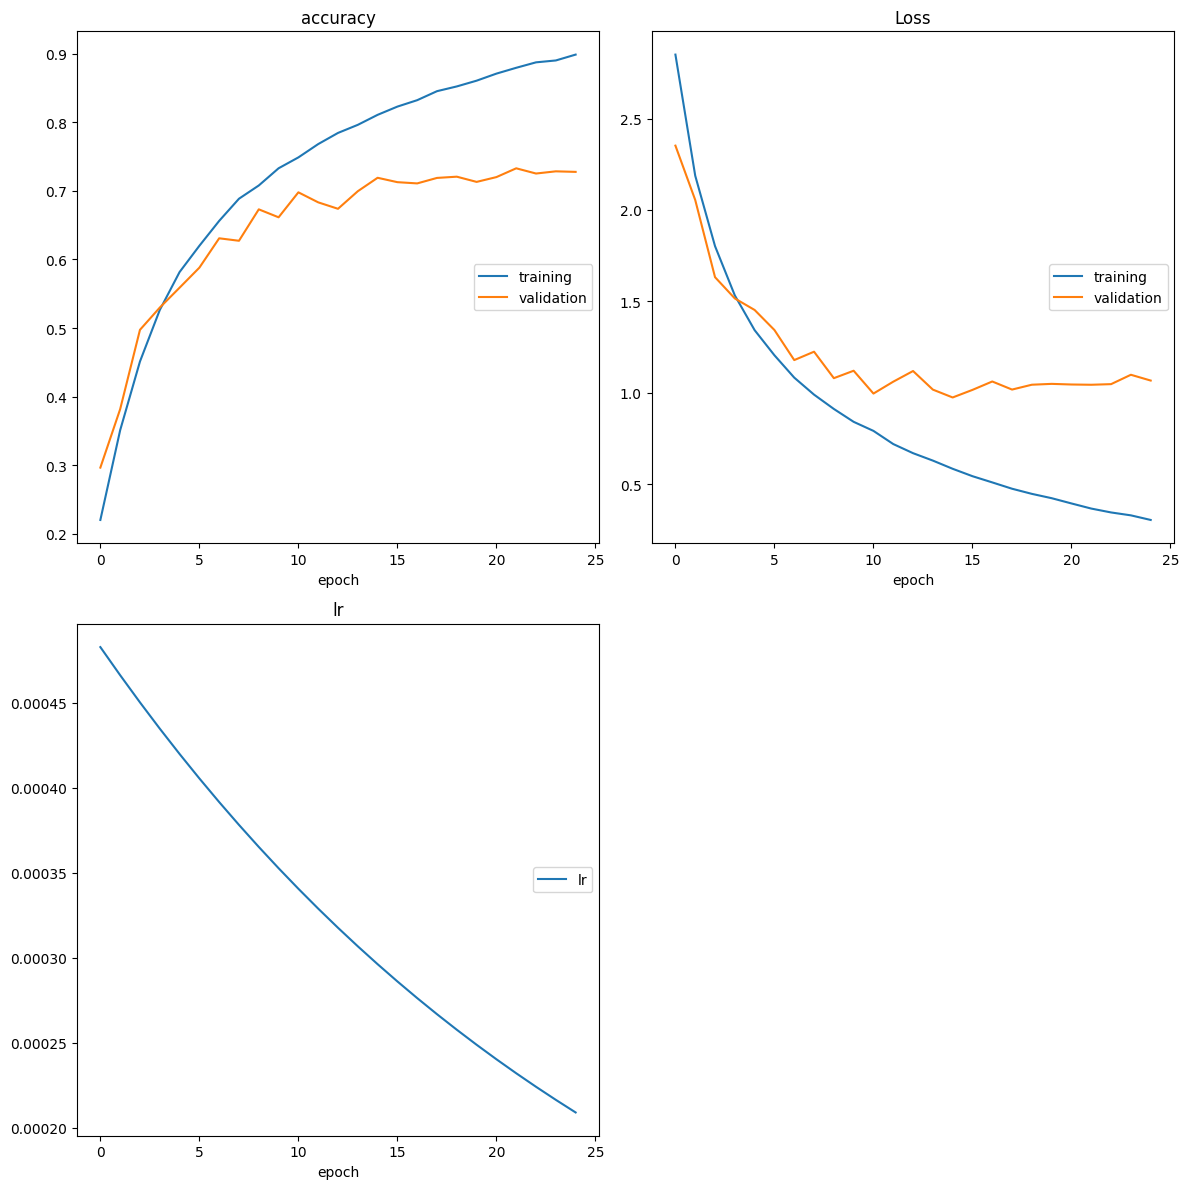

accuracy
	training         	 (min:    0.220, max:    0.899, cur:    0.899)
	validation       	 (min:    0.297, max:    0.733, cur:    0.728)
Loss
	training         	 (min:    0.304, max:    2.850, cur:    0.304)
	validation       	 (min:    0.974, max:    2.352, cur:    1.067)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
782/782 [==============================] - 28s 35ms/step - loss: 0.3040 - accuracy: 0.8985 - val_loss: 1.0667 - val_accuracy: 0.7276 - lr: 2.0896e-04
Epoch 25: early stopping


In [26]:
if TRAIN:
    coarse_model = build_model(20)
    coarse_history = coarse_model.fit(
        coarse_train,
        validation_data=coarse_val,
        epochs=100,
        callbacks=get_callbacks(),
    )
    coarse_model.save(src.utils.get_model_path("coarse"))
else:
    coarse_model = tf.keras.models.load_model(src.utils.get_model_path("coarse"))

In [54]:
if TRAIN:
    coarse_model = build_model(20)
    coarse_history = coarse_model.fit(
        coarse_train,
        validation_data=coarse_val,
        epochs=100,
        callbacks=get_callbacks(),
    )
    coarse_model.save(src.utils.get_model_path("coarse"))
else:
    coarse_model = tf.keras.models.load_model(src.utils.get_model_path("coarse"))

```
accuracy
	training         	 (min:    0.201, max:    0.873, cur:    0.873)
	validation       	 (min:    0.249, max:    0.710, cur:    0.710)
Loss
	training         	 (min:    0.386, max:    2.978, cur:    0.386)
	validation       	 (min:    1.040, max:    2.500, cur:    1.148)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

loss: 0.3861 - accuracy: 0.8729 - val_loss: 1.1479 - val_accuracy: 0.7096 - lr: 2.7070e-04
```

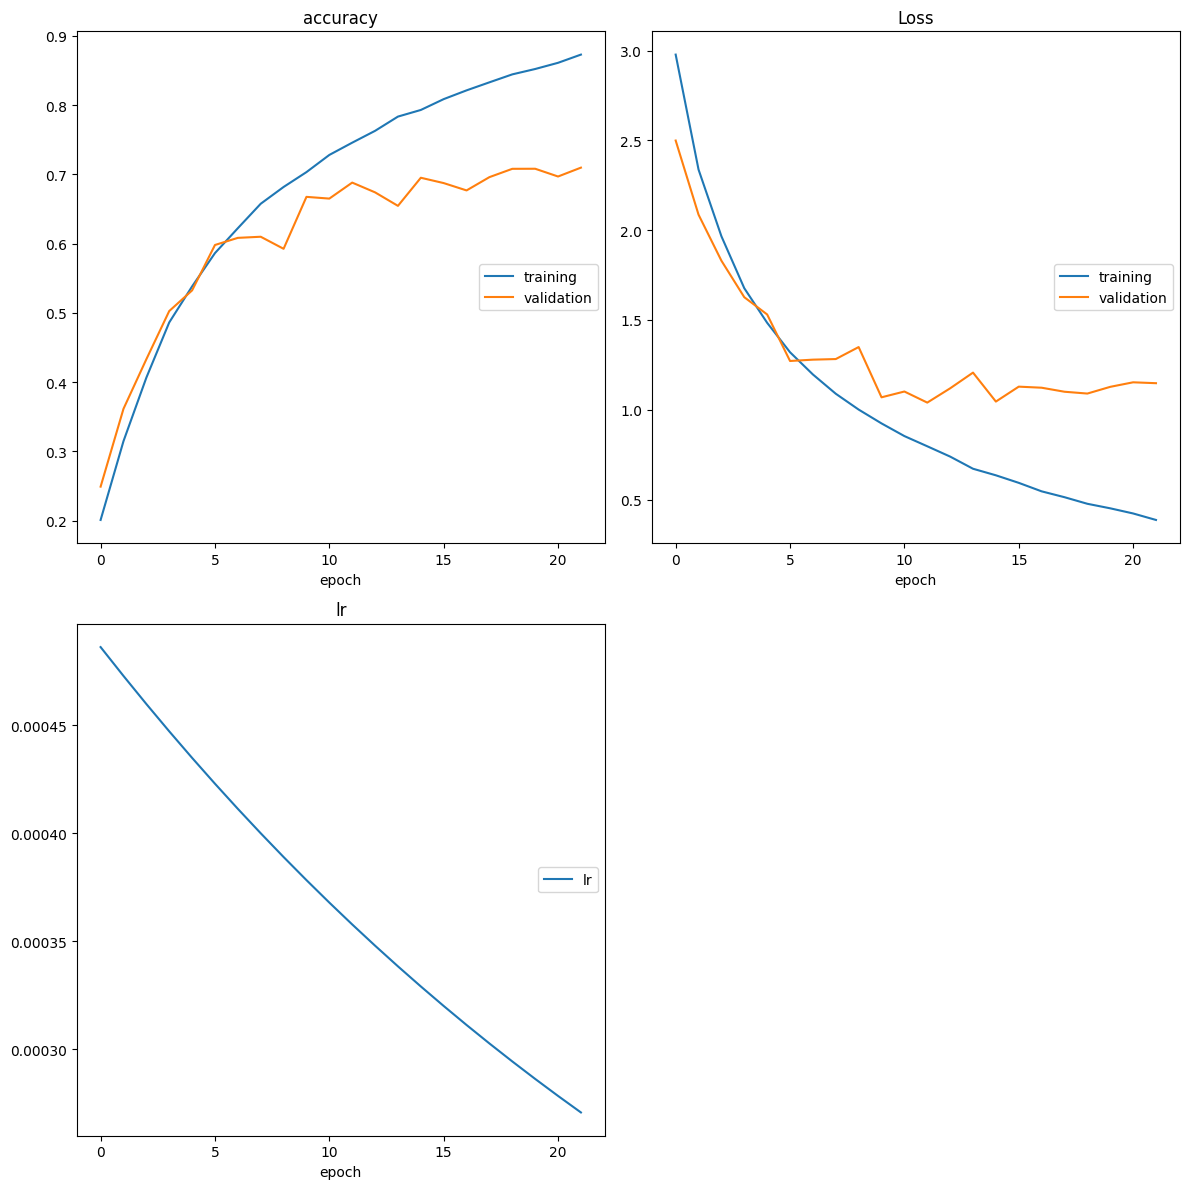

#### Обучение по узким меткам

In [55]:
if TRAIN:
    fine_model = build_model(100)
    fine_model.fit(
        fine_train,
        epochs=100,
        validation_data=fine_val,
        callbacks=get_callbacks(),
    )
    fine_model.save(
        src.utils.get_project_root().joinpath("./models").joinpath("./fine_model.keras")
    )
else:
    fine_model = tf.keras.models.load_model(src.utils.get_model_path("fine"))

```
accuracy
	training         	 (min:    0.090, max:    0.852, cur:    0.852)
	validation       	 (min:    0.131, max:    0.608, cur:    0.606)
Loss
	training         	 (min:    0.478, max:    4.444, cur:    0.478)
	validation       	 (min:    1.646, max:    3.835, cur:    1.809)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

loss: 0.4778 - accuracy: 0.8521 - val_loss: 1.8094 - val_accuracy: 0.6064 - lr: 2.4897e-04
```

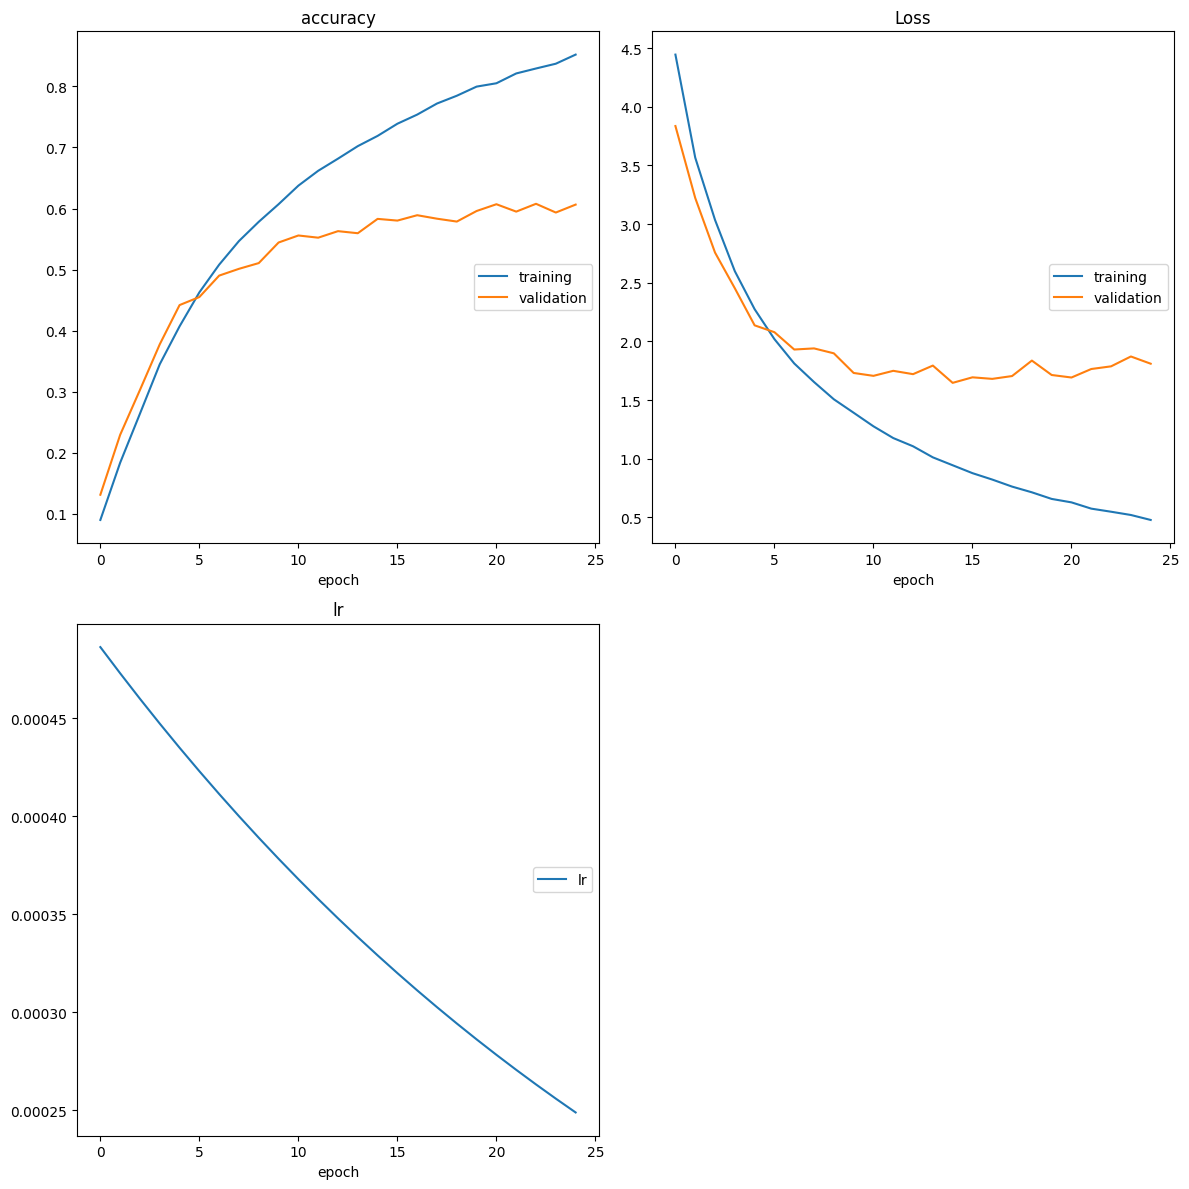

In [24]:
coarse_model.evaluate(coarse_test)

157/157 [==============================] - 1s 8ms/step - loss: 1.0213 - accuracy: 0.6885


[1.0212607383728027, 0.6884999871253967]

In [25]:
fine_model.evaluate(fine_test)

157/157 [==============================] - 1s 8ms/step - loss: 1.6054 - accuracy: 0.5914


[1.605351448059082, 0.5914000272750854]

### Итог обучения:

#### Coarse model:
loss: 0.3861 - accuracy: 0.8729 - val_loss: 1.1479 - val_accuracy: 0.7096 - lr: 2.7070e-04

Evluation:

- loss: 1.0212607383728027
- accuracy: 0.6884999871253967

#### Fine model:
loss: 0.4778 - accuracy: 0.8521 - val_loss: 1.8094 - val_accuracy: 0.6064 - lr: 2.4897e-04

Evluation:

- loss: 1.605351448059082
- accuracy: 0.5914000272750854


Как можно заметить по графикам обе модели под конец обучения переобучаются.

## Качество предсказаний

In [9]:
def evaluate_model(model: models.Model, test_ds: tf.data.Dataset):
    df = pd.DataFrame(test_ds.unbatch().as_numpy_iterator())

    X_true = np.array(df.iloc[:, 0].tolist())
    y_true = np.argmax(np.array(df.iloc[:, 1].tolist()), axis=1)

    y_predicted = np.argmax(model.predict(X_true), axis=1)

    return y_true, y_predicted

In [10]:
y_true_fine, y_predicted_fine = evaluate_model(fine_model, fine_test)
y_true_coarse, y_predicted_coarse = evaluate_model(coarse_model, coarse_test)

313/313 [==============================] - 1s 3ms/step


Обобщаем предсказания по узким классам до метки их широкого класса 

In [11]:
y_true_fine_coarsed = [fine_id_coarse_id[i] for i in y_true_fine]
y_predicted_fine_coarsed = [fine_id_coarse_id[i] for i in y_predicted_fine]

In [12]:
report_coarse = classification_report(
    y_true_coarse,
    y_predicted_coarse,
    target_names=coarse_int2str,
    digits=4,
)

print("Classification Report for Coarse Model:")
print(report_coarse)

Classification Report for Coarse Model:
                                precision    recall  f1-score   support

               aquatic_mammals     0.6540    0.5180    0.5781       500
                          fish     0.6726    0.6040    0.6365       500
                       flowers     0.8675    0.8120    0.8388       500
               food_containers     0.6315    0.7540    0.6873       500
          fruit_and_vegetables     0.7655    0.8160    0.7899       500
  household_electrical_devices     0.6606    0.6540    0.6573       500
           household_furniture     0.8667    0.7280    0.7913       500
                       insects     0.6000    0.7680    0.6737       500
              large_carnivores     0.7012    0.5820    0.6361       500
 large_man-made_outdoor_things     0.7932    0.7900    0.7916       500
  large_natural_outdoor_scenes     0.7620    0.8580    0.8071       500
large_omnivores_and_herbivores     0.6029    0.6680    0.6338       500
                medium_

In [13]:
report_fine = classification_report(
    y_true_fine_coarsed,
    y_predicted_fine_coarsed,
    target_names=coarse_int2str,
    digits=4,
)

print("Classification Report for Fine Model:")
print(report_fine)

Classification Report for Fine Model:
                                precision    recall  f1-score   support

               aquatic_mammals     0.6368    0.5820    0.6082       500
                          fish     0.6970    0.6900    0.6935       500
                       flowers     0.9109    0.7360    0.8142       500
               food_containers     0.7945    0.6880    0.7374       500
          fruit_and_vegetables     0.8502    0.7380    0.7901       500
  household_electrical_devices     0.5597    0.7500    0.6410       500
           household_furniture     0.7889    0.7700    0.7794       500
                       insects     0.6003    0.7840    0.6800       500
              large_carnivores     0.5756    0.7540    0.6528       500
 large_man-made_outdoor_things     0.7701    0.8240    0.7961       500
  large_natural_outdoor_scenes     0.9057    0.7880    0.8428       500
large_omnivores_and_herbivores     0.7893    0.5620    0.6565       500
                medium_ma

In [14]:
report_coarse = classification_report(
    y_true_coarse,
    y_predicted_coarse,
    digits=4,
    output_dict=True,
)
report_fine = classification_report(
    y_true_fine,
    y_predicted_fine,
    digits=4,
    output_dict=True,
)

In [15]:
accuracy_coarse = report_coarse["accuracy"]
accuracy_fine = report_fine["accuracy"]
print(f"Разница в точности: {accuracy_coarse - accuracy_fine}")

Разница в точности: 0.09709999999999996


Модель по широким меткам "точнее"

## Исследование метрик предсказаний с помощью графиков

In [26]:
exclude_keys = ["accuracy", "macro avg", "weighted avg"]

report_coarse = {k: v for k, v in report_coarse.items() if k not in exclude_keys}
report_fine = {k: v for k, v in report_fine.items() if k not in exclude_keys}

report_df_coarse = pd.DataFrame.from_dict(report_coarse).T
report_df_fine = pd.DataFrame.from_dict(report_fine).T

report_df_fine["coarse_id"] = report_df_fine.index.astype(int).map(fine_id_coarse_id)

grouped_df = (
    report_df_fine.rename_axis("fine_id")
    .groupby("coarse_id", group_keys=True)
    .apply(lambda x: x)
    .reset_index(0, drop=True)
    .join(
        report_df_coarse.reset_index(0, drop=True),
        on="coarse_id",
        how="left",
        rsuffix="_coarse",
    )
    .reset_index(0)
)
grouped_df["fine_id"] = grouped_df["fine_id"].apply(lambda x: fine_int2str[int(x)])
grouped_df["coarse_id"] = grouped_df["coarse_id"].apply(
    lambda x: coarse_int2str[int(x)]
)

In [17]:
def plot_metrics(metric):
    plt.figure(figsize=(20, 5))
    sns.barplot(
        grouped_df,
        x="fine_id",
        y=f"{metric}",
        palette=sns.color_palette("hls", 100),
        hue="fine_id",
    )
    plot_coarse = sns.barplot(
        grouped_df,
        x="fine_id",
        y=f"{metric}_coarse",
        palette="bright",
        hue="coarse_id",
        alpha=0.5,
    )
    plt.xticks(rotation=90)
    sns.move_legend(
        plot_coarse,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=10,
        frameon=False,
    )

    plt.legend(
        title="Метки широкого класса",
        ncols=5,
        mode="expand",
        bbox_to_anchor=(0.0, 1.3, 1.0, 0.102),
        loc="upper center",
    )
    plt.xlabel("")
    plt.title(metric)
    plt.show()

### Метрики

#### Precision

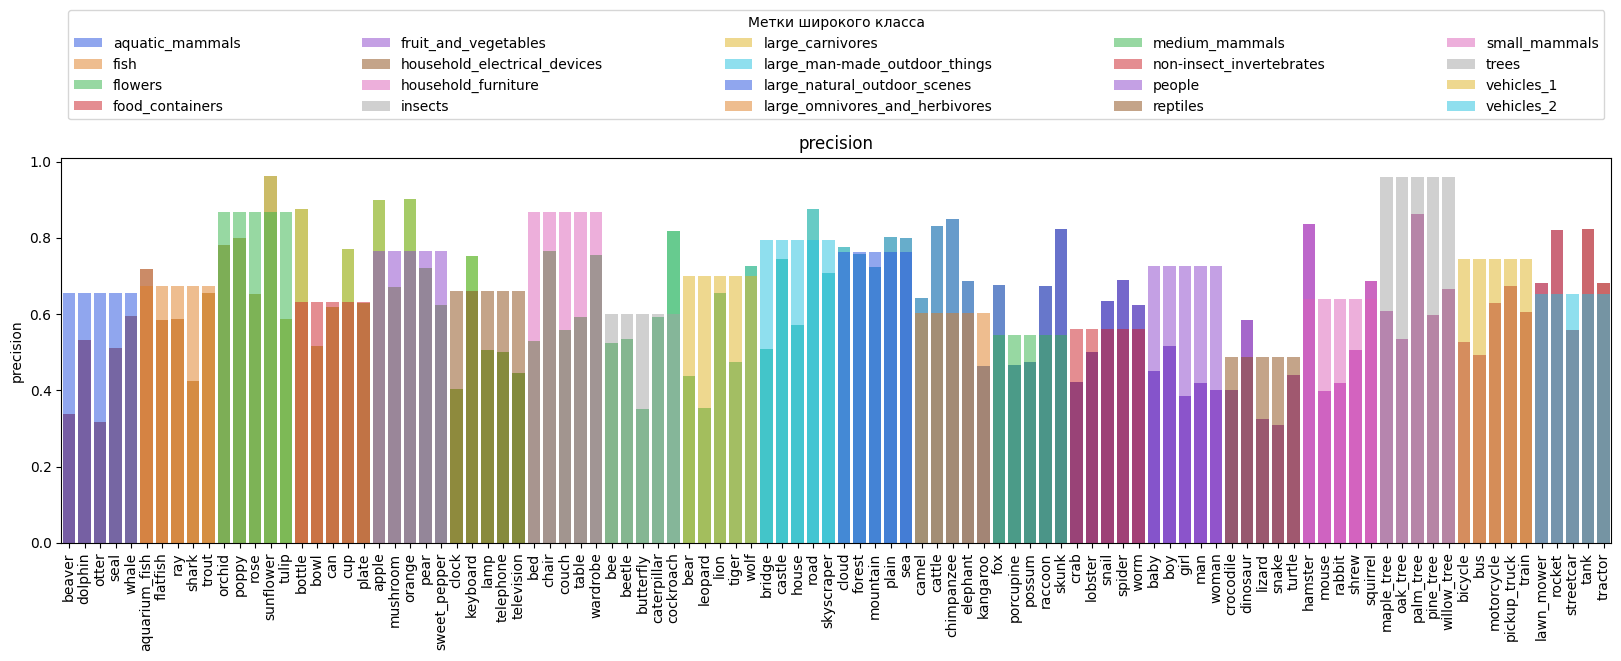

In [18]:
plot_metrics("precision")

#### Recall

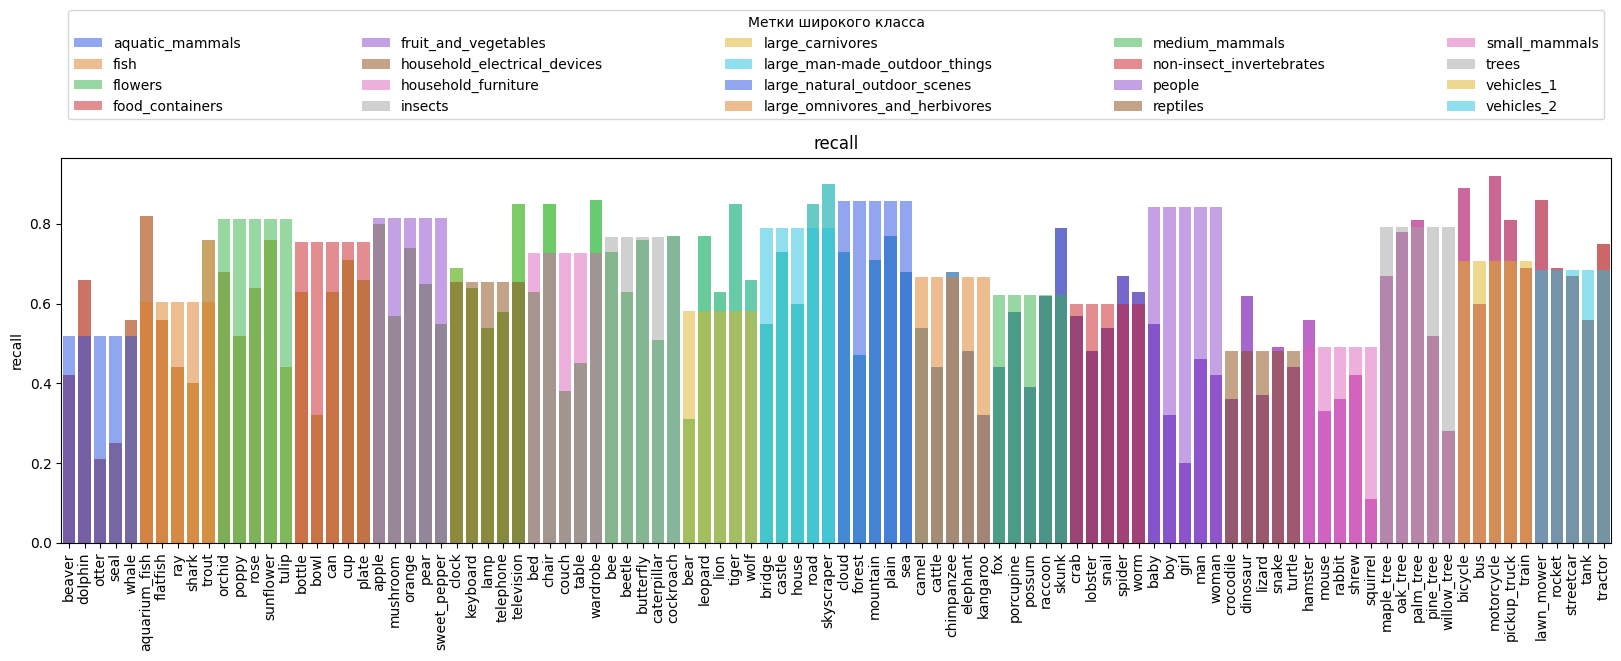

In [19]:
plot_metrics("recall")

#### F1-score

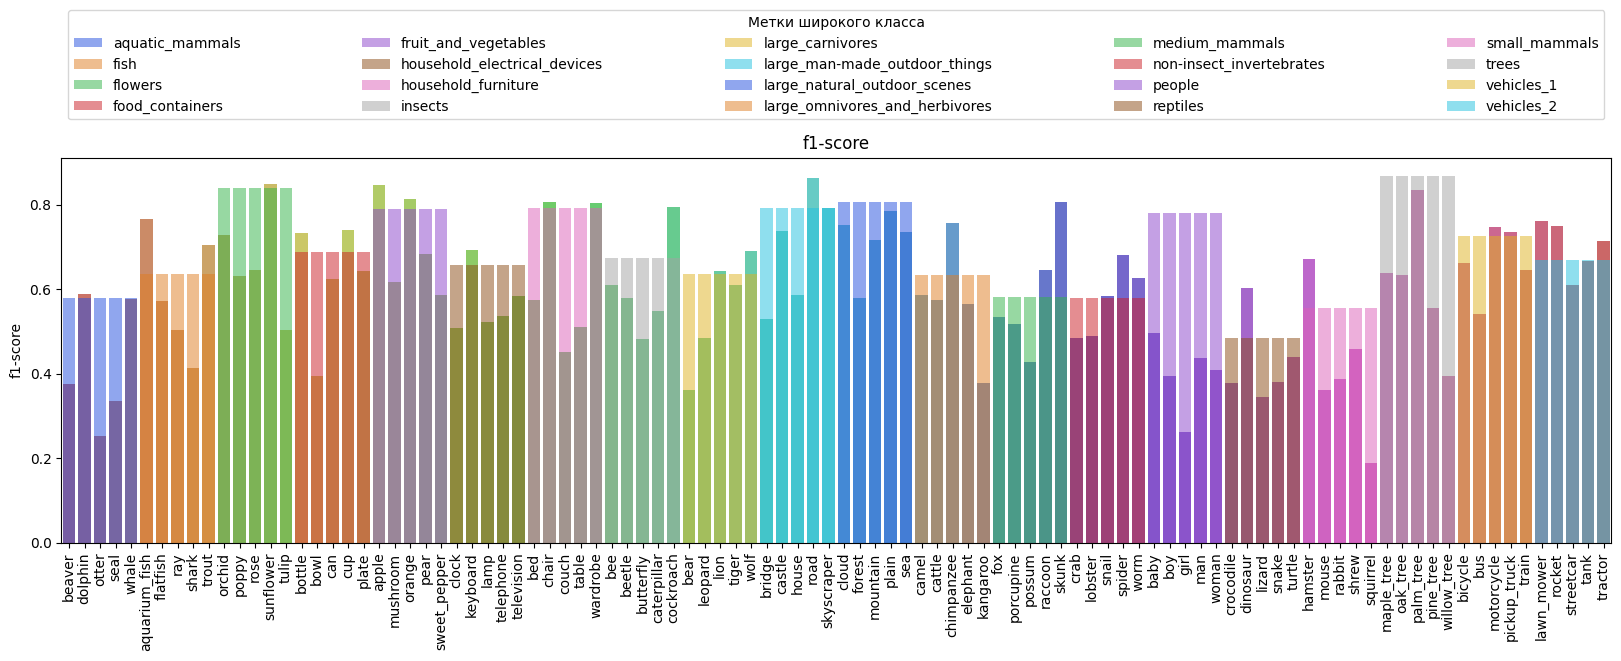

In [20]:
plot_metrics("f1-score")

### Наибольшие разницы между предсказанием по узкому классу от предсказання по широкому классу:

In [52]:
grouped_df["precision_diff"] = grouped_df["precision"] - grouped_df["precision_coarse"]
grouped_df["recall_diff"] = grouped_df["recall"] - grouped_df["recall_coarse"]
grouped_df["f1-score_diff"] = grouped_df["f1-score"] - grouped_df["f1-score_coarse"]

grouped_df["precision_diff"] = grouped_df["precision_diff"].abs()
grouped_df["recall_diff"] = grouped_df["recall_diff"].abs()
grouped_df["f1-score_diff"] = grouped_df["f1-score_diff"].abs()


top_diff_classes = grouped_df.nlargest(20, "precision_diff")
print(top_diff_classes[["fine_id", "coarse_id", "precision_diff"]])

        fine_id                      coarse_id  precision_diff
86     oak_tree                          trees        0.424591
88    pine_tree                          trees        0.361137
85   maple_tree                          trees        0.349747
41      leopard               large_carnivores        0.347994
72         girl                         people        0.342500
30          bed            household_furniture        0.337255
2         otter                aquatic_mammals        0.335859
74        woman                         people        0.327116
0        beaver                aquatic_mammals        0.315331
73          man                         people        0.308934
32        couch            household_furniture        0.307843
89  willow_tree                          trees        0.292171
45       bridge  large_man-made_outdoor_things        0.283913
14        tulip                        flowers        0.280855
64        skunk                 medium_mammals        0

## Итог:



Вероятно, у родительских классов есть большое разнообразие внутри себя.

Например, в случае с "trees", различные виды деревьев (oak, pine, maple) могут иметь разные характеристики, что затрудняет обобщение предсказаний для всего класса.

Так же вероятно, некоторые узкие классы могут быть довольно похожими на друг друга, что даёт низкие результаты предсказания.

Требуется рассмотреть возможности улучшения модели с помощью увеличения её возможности выделять признаки.